1.Implement Scaled Dot-Product Attention.


Write code for Q, K, V computation.


Visualize attention weights.

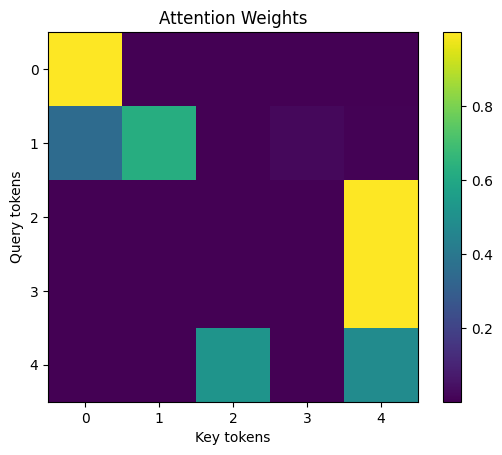

In [9]:
import torch
import torch.nn.functional as F
import math

def scaled_dot_product_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, V)
    return output, attn_weights

# Example
torch.manual_seed(0)
X = torch.randn(5, 8)  # 5 tokens, embedding dim 8

Wq = torch.randn(8, 8)
Wk = torch.randn(8, 8)
Wv = torch.randn(8, 8)

Q = X @ Wq
K = X @ Wk
V = X @ Wv

out, attn = scaled_dot_product_attention(Q, K, V)

import matplotlib.pyplot as plt

plt.imshow(attn.detach(), cmap="viridis")
plt.colorbar()
plt.xlabel("Key tokens")
plt.ylabel("Query tokens")
plt.title("Attention Weights")
plt.show()

2.Build Self-Attention from Scratch.


Implement a single-head self-attention layer in PyTorch/TensorFlow.

In [6]:
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        attn = F.softmax(scores, dim=-1)
        output = torch.matmul(attn, V)
        return output, attn

x = torch.randn(2, 5, 8)  # batch=2, tokens=5, dim=8
sa = SelfAttention(8)
out, attn = sa(x)

3.Implement Multi-Head Attention.


Extend single-head attention to multi-head.


Compare outputs across heads.

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)
        self.Wo = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, T, D = x.shape

        Q = self.Wq(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.Wk(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.Wv(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn = F.softmax(scores, dim=-1)

        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(B, T, D)
        return self.Wo(out), attn


mha = MultiHeadAttention(8, 2)
out, attn = mha(x)

# attn shape: [batch, heads, tokens, tokens]
print(attn[0, 0])  # head 0
print(attn[0, 1])  # head 1

tensor([[0.2831, 0.1537, 0.1640, 0.1454, 0.2539],
        [0.2008, 0.2481, 0.2373, 0.1505, 0.1633],
        [0.1602, 0.2463, 0.2392, 0.1799, 0.1744],
        [0.1331, 0.1918, 0.2571, 0.2790, 0.1389],
        [0.1370, 0.2892, 0.2700, 0.1505, 0.1533]], grad_fn=<SelectBackward0>)
tensor([[0.2802, 0.2081, 0.2445, 0.1456, 0.1216],
        [0.1790, 0.2002, 0.1248, 0.3269, 0.1691],
        [0.1879, 0.2272, 0.1486, 0.2590, 0.1773],
        [0.1537, 0.2162, 0.1663, 0.2183, 0.2455],
        [0.1677, 0.2379, 0.1555, 0.2428, 0.1961]], grad_fn=<SelectBackward0>)


4.Attention Visualization.


Use BERTViz or custom code to visualize attention maps.


Interpret which tokens influence predictions.

In [ ]:
pip install bertviz transformers

In [14]:
from transformers import BertTokenizer, BertModel
from bertviz import head_view

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

inputs = tokenizer("Attention helps models focus", return_tensors="pt")
outputs = model(**inputs)

head_view(outputs.attentions, tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


<IPython.core.display.Javascript object>

5.Head Importance Analysis.


Remove one attention head at a time.


Measure impact on accuracy.

In [13]:
def mask_head(attn, head_idx):
    attn[:, head_idx] = 0
    return attn

6.Transformer Encoder Block.


Implement a full encoder block (Attention + FFN + LayerNorm).

In [16]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, _ = self.attn(x)
        x = self.norm1(x + attn_out)

        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

7.Positional Encoding Experiment.

Implement sinusoidal positional encoding.

Compare with learned positional embeddings.

In [19]:
def positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

x = x + positional_encoding(x.size(1), x.size(2))

pos_embed = nn.Embedding(max_len, embed_dim)
positions = torch.arange(0, T)
x = x + pos_embed(positions)

NameError: name 'max_len' is not defined